# Build CNN input samples with width = heigth

#### Hypothesis
We believe that behind each crisis period there are patterns on stock behavior that can be recognized the same way that a dog can be recognized in a picture training a convolutional neural network.

There may be several patterns, we should include stock prices time series from several indexes and relevant companies in order to learn the whole picture. For the moment, we only want to build the infrastructure with S&P 500 index.

#### Time series input data
The data that we downloaded from yahoo finance is a time series from 1951 to 2017. This means that we have a data set with dimensions 24090x1x1 (considering width as each day). 

The time series was transformed to logarithmic scale and decomposed in trend, seasonality and residuals with a frequency of 5 years. Thus, we could say that our input data changed its dimensions to 24090x1x3. 


#### Time series input data labeling
Additionally, we labeled the data as described in the notebook "Explore KPIs to predict the crisis.ipynb" in the step "Can we recognize crisis considering values far from the mean of the residuals?". For the labeling, the data was also decomposed but the decomposition was done considering two sides of the time series in this case. Only the residuals were considered for assigning the labeling, the distribution of residual frequencies was splitted in three types:
* left tail [0, mean - 1 * std] ==> Crisis
* around mean [mean - 1 * std, mean + 1 * std] ==> Normal
* right tail [mean + 1 * std, inf] ==> Before crisis

We verified that the labeling identifies all crisis during the last 70 years.

#### Transform labeled time series to CNN like input data
Once we have the stock prices decomposed and labeled, the dimensions of our data is 20440x1x4 (notice that 365*5*2 days are removed since the decomposition for labeling was two sided). Now come the question *How do we split the data in blocks with same width and height that contains the patterns that we want to learn from? Blocks of 30 days? 90 days?*.

Independently of the type of model that we want to use for learning stock price patterns of a crisis, we need to create blocks of stock prices of a given time length with the right label. Thus, we need to find the right time length for each block and assign the right label.

We study in this notebook the distribution of the lengths for each type of period (before crisis high prices, crisis and normal) in order to find out if there is a common amount of days that define each period.

###### Why CNN instead of RF, SVM, RNN or FC neural network?
We want to be able to recognize a specific pattern on stock price changes before and during the crisis. Our input data is the time series of the stock prices at the opening time every day. 

A decision tree seems to not be the best approach since the features are not independent but there is a dependency on the order in which the data is presentet.

On the other hand, a recurrent neural network is not necessary the best approach neither since the order of occurrence of the events it is not relevant. We see that the period of time between events is not similar but the shape of changes before and during crisis.

Our hypothesis is that there are common patterns on the behavior of stock price changes when special events like time before a crisis are happening. We assume that if we split the data in the right amount of days and we learn the shape of the time series decomposed during special events training a convolutional neural network, we will be able to recognize any special event in any stock market time series given. In order to train the CNN better, we may include time series from different stock indexes and markets. In the current notebook we will just work with S&P 500 data as a proof of concept. 

In order to recognize different stages of the special events, we will build samples out of a given number of days and the sequence will be shown at differnt window sizes. Thus, we learn how to recognize the event at different stages as shown in the picture.

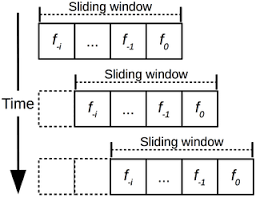

We do not discard that SVM or a full connected neural network will also obtain good performance on the special events recognition. This will be also tested in the future.

In [45]:
import datetime
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf
import timeit
import warnings
warnings.filterwarnings('ignore')

## Explore frequency distribution of periods with the same label

In [46]:
def log_scale_and_decompose_time_series(data, column_to_decompose, frequency, model='multiplicative', two_sided=False):
    data_ = data.copy()
    
    # Manual extraction of the exponential trend applying the logarithm of the values
    log_column_name = 'log_' + column_to_decompose
    data_[log_column_name] = data_[column_to_decompose].apply(lambda x: np.log(x))
    
    # Decompose log_trend_open in log_trend_open_trend, log_trend_open_season, log_trend_open_resid
    result_open = seasonal_decompose(data_[log_column_name].tolist(), model=model, freq=frequency, 
                                 two_sided=two_sided)
    result_open.plot()
    plt.show()
    
    trend_column_name = 'log_' + column_to_decompose + '_trend' 
    seasonal_column_name = 'log_' + column_to_decompose + '_seasonal' 
    residual_column_name = 'log_' + column_to_decompose + '_residual' 
    data_[trend_column_name] = result_open.trend
    data_[seasonal_column_name] = result_open.seasonal
    data_[residual_column_name] = result_open.resid
    
    return data_

def exp_scale_and_recompose_time_series(series_trend, series_seasonal, series_residual):
    return np.exp(series_trend * series_seasonal * series_residual)

In [47]:
# Use previously annotated by distribution of residual values 
# annotation of the distribution: crisis: [0,mean-1*std], normal: [mean-1*std,mean+1*std], 
# before crisis:[mean+1*std,inf]
sp500 = pd.read_csv('../data/S_and_P_500_50_18_crisis.csv')
sp500['Date'] = pd.to_datetime(sp500['Date'])

# Assign names to annotation of the distribution of stock prices: crisis: [0,mean-1*std], 
# normal: [mean-1*std,mean+1*std], before crisis:[mean+1*std,inf]
sp500.stock_price_annot = sp500.stock_price_annot.replace(to_replace=['mode_1','mode_2','mode_3'], 
                                                          value=['crisis','normal','before_crisis'])
sp500['stock_price_target'] = 0
sp500.ix[sp500[sp500['stock_price_annot'] == 'crisis'].index,'stock_price_target'] = 1
sp500.ix[sp500[sp500['stock_price_annot'] == 'before_crisis'].index,'stock_price_target'] = 2

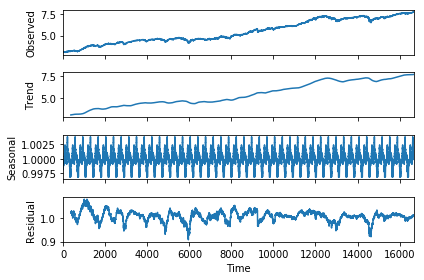

In [64]:
frequency = 365*1
sp500_decomposed = log_scale_and_decompose_time_series(sp500, 'Open', frequency, model='multiplicative', two_sided=False)
data = sp500_decomposed.ix[frequency:,['Date_str', 'log_Open_trend','log_Open_seasonal',
                                       'log_Open_residual','stock_price_target']].reset_index(drop=True)

In [65]:
seq_period = data['stock_price_target'].tolist()

frequency = []
for key, iter in itertools.groupby(seq_period):
    frequency.append([key, len(list(iter))])

label_freq = pd.DataFrame(frequency).rename(columns={0:'label',1:'frequency'})
label_freq_comparison = pd.concat([label_freq[label_freq['label']==0], label_freq[label_freq['label']==1], 
                                   label_freq[label_freq['label']==2]])
label_freq_comparison['label'] = label_freq_comparison['label'].replace(to_replace=[0,1,2], 
                                                                            value=['crisis','normal','before_crisis'])
label_freq_comparison_short = label_freq_comparison[label_freq_comparison['frequency'] < 10000000]

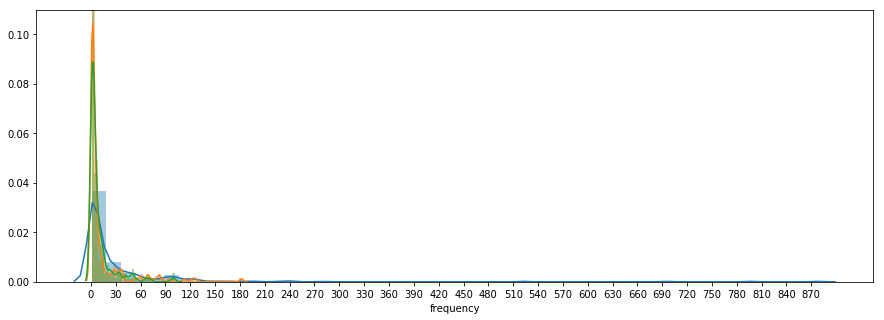

In [66]:
plt.figure(figsize=(15,5))
sns.distplot(label_freq_comparison_short[label_freq_comparison_short['label']=='crisis']['frequency'])
sns.distplot(label_freq_comparison_short[label_freq_comparison_short['label']=='normal']['frequency'])
sns.distplot(label_freq_comparison_short[label_freq_comparison_short['label']=='before_crisis']['frequency'])
_ = plt.xticks(np.arange(min(label_freq_comparison_short[label_freq_comparison_short['label']=='crisis']['frequency'])-1, 
                     max(label_freq_comparison_short[label_freq_comparison_short['label']=='crisis']['frequency'])+1, 
                     30))

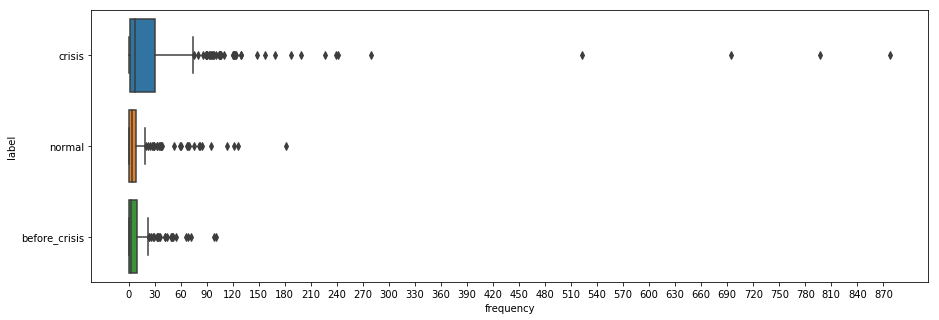

In [67]:
plt.figure(figsize=(15,5))
sns.boxplot(x='frequency', y='label', data=label_freq_comparison_short)
_ = plt.xticks(np.arange(min(label_freq_comparison_short[label_freq_comparison_short['label']=='crisis']['frequency'])-1, 
                     max(label_freq_comparison_short[label_freq_comparison_short['label']=='crisis']['frequency'])+1, 
                     30))

* We see that the median for the three labels is less than 10 days.
* On the other hand, if we consider 35 days then we include the first two quartiles for the three distributions.

## Build CNN input data with the best time frame for width & heith (35x35)

* The whole time series will be splitted in time series of 35 days.
* Each day will have 3 dimensions (trend, season, residual).
* We will generate a matrix of 35x35 dimensions per sample where each column will be one day and each row will be a different window size showing those 35 days. 
* The gaps will be filled up with zeros.

In [147]:
def generate_cnn_input_datasets(data, width_height, depth, n_days_left):
    
    dates = []
    samples = []
    labels = []
    
    counter = n_days_left - 1
    
    for sample in range(1, n_samples + 1):
        sample_i = np.zeros((width_height, width_height, depth))
        frame = data.loc[counter:counter + width_height - 1]
    
        # save the dates of each sequence for labeling purposes during evaluation
        date_i = data.ix[counter, 'Date_str']
        date_f = data.ix[counter + width_height, 'Date_str']
        date_name = date_i + '_' + date_f
        dates.append(date_name)
    
        # select the sequence of data
        x = frame.loc[:,['log_Open_trend','log_Open_seasonal','log_Open_residual']].reset_index(drop=True)
    
        # assign the label of the most common label in the selected sequence
        y = frame.loc[:,'stock_price_target'].mode().values[0]
        labels.append(y)
    
        # build sample 35x35x3 for each sequence block
        for day in x.index.tolist():
            row = x.loc[:day].values
            
            # for each day in the given window size
            for i in range(day+1):
                sample_i[day,i] = row[i]
    
        samples.append(sample_i)
        counter += width_height
    
    return samples, labels, dates

In [157]:
width_height = 32
depth = 3
n_samples = int(len(data) / width_height)
n_days_left = len(data) % width_height
n_days_zeros = width_height - n_days_left
print("We have {} samples of {} days and {} are left so we will fill them up with zeros.".format(n_samples,
                                                                                                 width_height,
                                                                                                 n_days_left))

We have 510 samples of 32 days and 6 are left so we will fill them up with zeros.


In [155]:
samples, labels, dates = generate_cnn_input_datasets(data, width_height, depth, n_days_left)

In [156]:
np.save('../data/x_samples', samples)
np.save('../data/y_labels', labels)
np.save('../data/date_sequences', dates)